In [6]:
# filelist
import platform
import cv2
import numpy as np
import os
from pathlib import Path

root = os.getcwd() # Don't change this
data_dirname = '/data_test/plantvillage/' # Change as you like 
p = Path(root + data_dirname)
p.mkdir(exist_ok=True) 
if platform.system()=='Darwin':
  root = os.getcwd() # Don't change this
  data_dirname = '/data_test/plantvillage/' # Change as you like 
  p = Path(root + data_dirname)
  p.mkdir(exist_ok=True) 
#else:
#  p = Path("C:/Users/mwels/Documents/Uni/11. Semester/Deep learning in visual recognition/Plant_leave_diseases_dataset_without_augmentation")
#  p.mkdir(exist_ok=True)


classes = [
  'Apple___Apple_scab',
  'Apple___healthy',
  'Apple___Black_rot',
  'Apple___Cedar_apple_rust',
  "all"
  ]

if "all" in classes:
  classes = os.listdir(p)

for c in classes:
  print(c,end=" ")
  filelist = [x for x in (p/c).iterdir() if x.is_file()]
  for f in filelist:
    img = cv2.imread(str(f))
    if img is None:
      print(f'Failed to open {f}. Deleting file')
      os.remove(str(f))
# Pick first image of first class (i.e., cat)
# filelist = [x for x in (p/classes[0]).iterdir() if x.is_file()]
print(len(filelist))

Apple___Apple_scab Apple___Black_rot Apple___Cedar_apple_rust Apple___healthy 1645


In [7]:
from keras.applications.mobilenet import MobileNet
from keras.applications.mobilenet import preprocess_input

conv_base = MobileNet(weights='imagenet',
                      include_top=False,
                      input_shape=(40, 40, 3))
type(conv_base)

17225924/17225924 [==============================] - 1s 0us/step


keras.engine.functional.Functional

In [8]:
from keras.layers import Dense,GlobalAveragePooling2D, Concatenate, Input, Flatten, Lambda, Layer
from keras.models import Model
from src import fenchel_young
from src import perturbations
import tensorflow as tf
#Custom ranking layer
class Ranking(Layer):
    def __init__(self, num_samples=1000000, sigma=0.1, noise='gumbel', batched=True):
        self.num_samples = num_samples
        self.sigma = sigma
        self.noise = noise
        self.batched=batched
        super(Ranking, self).__init__()

    def call(self, inputs):
        @perturbations.perturbed(num_samples=self.num_samples, sigma=self.sigma, noise=self.noise, batched=self.bathced)
        def ranks_fn(x, axis=-1):
            return tf.cast(tf.argsort(tf.argsort(x, axis=axis), axis=axis), dtype=x.dtype)

        return ranks_fn(inputs)
#Split input layer
class TestL(Layer):
    def __init__(self, regularization_strength = 1):
        self.regularization_strength = regularization_strength
        super(TestL, self).__init__()

    def call(self, inputs):
        
        return tf.tensordot(inputs,tf.convert_to_tensor([1.2,2,3]),0)

In [9]:
Ranking()(Input(3))

<KerasTensor: shape=(None, 3) dtype=float32 (created by layer 'ranking')>

In [37]:
from src import fenchel_young
from src import perturbations
#import gin
#@gin.configurable
#@perturbations.perturbed(num_samples=1000000, sigma=0.5, noise='gumbel', batched=True)
def ranks_fn(x, axis=-1):
  return tf.cast(tf.argsort(tf.argsort(x, axis=axis), axis=axis), dtype=x.dtype)

print(ranks_fn(tf.convert_to_tensor([[1.,0.2,3],[0.,1,2]])))

myloss = fenchel_young.FenchelYoungLoss(ranks_fn, num_samples=1000000, sigma=0.1, noise='gumbel', batched=True)
a = tf.convert_to_tensor([[1.,2,0],[0.,1,2]])
b = tf.convert_to_tensor([[0.5,1,0.2],[0.,1,1.2]])
print(myloss(a,b).numpy())
a = tf.convert_to_tensor([[1.,2,0],[0.,1,2]])
b = tf.convert_to_tensor([[1,2,0.2],[0.,1,1.2]])
print(myloss(a,b).numpy())

tf.Tensor(
[[1. 0. 2.]
 [0. 1. 2.]], shape=(2, 3), dtype=float32)
0.032242116
0.028475448


In [31]:
from src.fast_soft_sort.tf_ops import soft_rank
class RankingLoss(tf.keras.losses.Loss):

    def call(self, y_true, y_pred):
        @tf.custom_gradient
        def loss(self,y_true, y_pred):
            diff = soft_rank(y_pred)-tf.cast(y_true,  dtype=y_pred.dtype)
    

            def grad(dy):
                dy = tf.reshape(dy, [tf.shape(dy)[0]] + (diff.shape.rank - 1) * [1])
                return dy*diff


            return 0.5*tf.square(diff)
        
        return self.loss(y_true, y_pred)

In [15]:
from re import L
import tensorflow as tf

out = Input(3)
print(out)
Layer = TestL(0.1)(out)
print(Layer)
end = Dense(3)(Layer)
print(end)

KerasTensor(type_spec=TensorSpec(shape=(None, 3), dtype=tf.float32, name='input_3'), name='input_3', description="created by layer 'input_3'")
KerasTensor(type_spec=TensorSpec(shape=(None, 3, 3), dtype=tf.float32, name=None), name='test_l/Tensordot:0', description="created by layer 'test_l'")
KerasTensor(type_spec=TensorSpec(shape=(None, 3, 3), dtype=tf.float32, name=None), name='dense/BiasAdd:0', description="created by layer 'dense'")


In [ ]:
class TestL(Layer):
    def __init__(self, regularization_strength = 1):
        self.regularization_strength = regularization_strength
        super(TestL, self).__init__()

    def call(self, inputs):
        
        return tf.tensordot(inputs,tf.convert_to_tensor([1.2,2,3]),0)

In [40]:
from keras.layers import Dense,GlobalAveragePooling2D, Concatenate, Input, Flatten, Lambda, Layer
from keras.models import Model


number_of_tiles = 9
image_net = conv_base
tiles = Input((9,40,40,3))
tile1 = Lambda(lambda x: x[:,0,:,:,:])(tiles) 
tile2 = Lambda(lambda x: x[:,1,:,:,:])(tiles) 
tile3 = Lambda(lambda x: x[:,2,:,:,:])(tiles) 
tile4 = Lambda(lambda x: x[:,3,:,:,:])(tiles) 
tile5 = Lambda(lambda x: x[:,4,:,:,:])(tiles) 
tile6 = Lambda(lambda x: x[:,5,:,:,:])(tiles) 
tile7 = Lambda(lambda x: x[:,6,:,:,:])(tiles) 
tile8 = Lambda(lambda x: x[:,7,:,:,:])(tiles) 
tile9 = Lambda(lambda x: x[:,8,:,:,:])(tiles) 
tile1 = preprocess_input(tile1) 
tile2 = preprocess_input(tile2) 
tile3 = preprocess_input(tile3) 
tile4 = preprocess_input(tile4) 
tile5 = preprocess_input(tile5) 
tile6 = preprocess_input(tile6) 
tile7 = preprocess_input(tile7) 
tile8 = preprocess_input(tile8) 
tile9 = preprocess_input(tile9) 

embedding_of_tile1 = image_net(tile1) 
embedding_of_tile2 = image_net(tile2)
embedding_of_tile3 = image_net(tile3) 
embedding_of_tile4 = image_net(tile4) 
embedding_of_tile5 = image_net(tile5) 
embedding_of_tile6 = image_net(tile6)
embedding_of_tile7 = image_net(tile7)
embedding_of_tile8 = image_net(tile8)
embedding_of_tile9 = image_net(tile9)

concatonation = Concatenate(axis=3)([
    embedding_of_tile1,
    embedding_of_tile2,
    embedding_of_tile3,
    embedding_of_tile4,
    embedding_of_tile5,
    embedding_of_tile6,
    embedding_of_tile7,
    embedding_of_tile8,
    embedding_of_tile9
    ])

out = Dense(500, activation="relu")(concatonation)
# out = Dense(500, activation="relu")(out)
out = Dense(9)(out)
out = Flatten()(out)
out = Ranking()(out)

model = Model(inputs=tiles, outputs=out)

In [41]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 9, 40, 40,   0           []                               
                                3)]                                                               
                                                                                                  
 lambda_9 (Lambda)              (None, 40, 40, 3)    0           ['input_5[0][0]']                
                                                                                                  
 lambda_10 (Lambda)             (None, 40, 40, 3)    0           ['input_5[0][0]']                
                                                                                                  
 lambda_11 (Lambda)             (None, 40, 40, 3)    0           ['input_5[0][0]']          

In [42]:
total_num_layers = len(model.layers)
num_base_layers = len(conv_base.layers)
print(f"Total number of layers is {total_num_layers}")
print(f"Number of pretrained base layers is {num_base_layers}")

for layer in model.layers[:-4]:
    layer.trainable=False
for layer in model.layers[-4:]:
    layer.trainable=True

Total number of layers is 34
Number of pretrained base layers is 86


In [19]:
class PartialRanksAccuracy(tf.keras.metrics.Mean):
  """This metric the proportion of matching ranks."""

  def __init__(self, name='partial_ranks_acc'):
    super().__init__(name=name)

  def update_state(self, y_true, y_pred, sample_weight=None):
    y_pred = tf.cast(ranks_fn(y_pred, axis=-1), tf.int32)
    y_true = tf.cast(y_true, tf.int32)
    equals = tf.cast(y_true == y_pred, tf.float32)
    result = tf.math.reduce_mean(equals, axis=-1)
    super().update_state(
        tf.reduce_mean(result, axis=-1), sample_weight=sample_weight)

class ProjectedRanksAccuracy(tf.keras.metrics.Mean):
  """This metric is the normalized projection onto the permutahedron."""

  def __init__(self):
    super().__init__(name='projection_ranks_acc')

  def update_state(self, y_true, y_pred, sample_weight=None):
    y_pred = tf.cast(ranks_fn(y_pred, axis=-1), tf.float32)
    y_true = tf.cast(y_true, tf.float32)
    n = tf.cast(tf.shape(y_true)[-1], tf.float32)
    max_proj = (n - 1.0) * n * (2.0 * n - 1.0) / 6.0
    result = tf.math.reduce_sum(y_true * y_pred, axis=-1) / max_proj
    super().update_state(
        tf.reduce_mean(result, axis=-1), sample_weight=sample_weight)

In [46]:
#NEW BETTER MODEL MSE
from keras import optimizers
from sklearn.model_selection import train_test_split
from src.permutation_tools import *
import tensorflow_ranking as tfr 

x_train, x_test = train_test_split(filelist)

train_generator = PermNetDataGenerator([x_train[0]]*256, 1)
validation_generator = PermNetDataGenerator(x_test)


# Set up optimizer
sgd_optimizer = optimizers.SGD(learning_rate=0.001, decay=1e-6, momentum=0.9, nesterov=True)

# Compile model 
# softmax_loss = tfr.keras.losses.get(tfr.keras.losses.RankingLossKey.MEAN_SQUARED_LOSS)
model.compile(optimizer=sgd_optimizer,loss=tf.keras.losses.MeanSquaredError(), metrics=[ProjectedRanksAccuracy(), PartialRanksAccuracy()])

# Train model for 150 epochs
history = model.fit(train_generator,epochs=50)

Epoch 1/50
256/256 [==============================] - 59s 189ms/step - loss: 6.8365 - projection_ranks_acc: 0.7010 - partial_ranks_acc: 0.1163
Epoch 2/50
256/256 [==============================] - 48s 189ms/step - loss: 6.8264 - projection_ranks_acc: 0.7067 - partial_ranks_acc: 0.1050
Epoch 3/50
256/256 [==============================] - 50s 194ms/step - loss: 6.7937 - projection_ranks_acc: 0.7120 - partial_ranks_acc: 0.1233
Epoch 4/50
256/256 [==============================] - 49s 193ms/step - loss: 6.7718 - projection_ranks_acc: 0.7179 - partial_ranks_acc: 0.1159
Epoch 5/50
256/256 [==============================] - 53s 207ms/step - loss: 6.8306 - projection_ranks_acc: 0.7038 - partial_ranks_acc: 0.1163
Epoch 6/50
256/256 [==============================] - 52s 202ms/step - loss: 6.7821 - projection_ranks_acc: 0.7080 - partial_ranks_acc: 0.1150
Epoch 7/50
 95/256 [==========>...................] - ETA: 31s - loss: 6.8005 - projection_ranks_acc: 0.7115 - partial_ranks_acc: 0.1029

KeyboardInterrupt: 

In [21]:
#NEW BETTER MODEL
from keras import optimizers
from sklearn.model_selection import train_test_split
from src.permutation_tools import *
import tensorflow_ranking as tfr 

x_train, x_test = train_test_split(filelist)

train_generator = PermNetDataGenerator([x_train[0]]*512, 16)
validation_generator = PermNetDataGenerator(x_test)


# Set up optimizer
sgd_optimizer = optimizers.SGD(learning_rate=0.001, decay=1e-6, momentum=0.9, nesterov=True)

# Compile model 
# softmax_loss = tfr.keras.losses.get(tfr.keras.losses.RankingLossKey.MEAN_SQUARED_LOSS)
model.compile(optimizer=sgd_optimizer,loss=myloss, metrics=[ProjectedRanksAccuracy(), PartialRanksAccuracy()])

# Train model for 150 epochs
history = model.fit(train_generator,epochs=150)

Epoch 1/150
32/32 [==============================] - 74s 2s/step - loss: 1105.9563 - projection_ranks_acc: 0.7058 - partial_ranks_acc: 0.1094
Epoch 2/150
32/32 [==============================] - 64s 2s/step - loss: 1001.7000 - projection_ranks_acc: 0.7050 - partial_ranks_acc: 0.1092
Epoch 3/150
32/32 [==============================] - 65s 2s/step - loss: 1017.5155 - projection_ranks_acc: 0.7007 - partial_ranks_acc: 0.1055
Epoch 4/150
32/32 [==============================] - 65s 2s/step - loss: 1004.6848 - projection_ranks_acc: 0.7129 - partial_ranks_acc: 0.1200
Epoch 5/150
32/32 [==============================] - 65s 2s/step - loss: 1002.2037 - projection_ranks_acc: 0.7057 - partial_ranks_acc: 0.1102
Epoch 6/150
32/32 [==============================] - 65s 2s/step - loss: 1012.7784 - projection_ranks_acc: 0.7019 - partial_ranks_acc: 0.1059
Epoch 7/150
32/32 [==============================] - 65s 2s/step - loss: 1022.1761 - projection_ranks_acc: 0.6942 - partial_ranks_acc: 0.1092
Epoch 

KeyboardInterrupt: 

1/1 [==============================] - 0s 31ms/step


<tf.Tensor: shape=(1, 9), dtype=float32, numpy=array([[2., 6., 0., 3., 7., 8., 5., 1., 4.]], dtype=float32)>

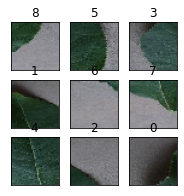

In [38]:
test_gen = PermNetDataGenerator([x_train[0]]*512, 16)
X, y = test_gen.next()
showPermImg(X[0], y[0])
ranks_fn(model.predict(np.expand_dims(X[0], 0)))

In [ ]:
from keras import optimizers
from sklearn.model_selection import train_test_split
from src.permutation_tools import *
import tensorflow_ranking as tfr 

x_train, x_test = train_test_split(filelist)

train_generator = PermNetDataGenerator(x_train)
validation_generator = PermNetDataGenerator(x_test)


# Set up optimizer
sgd_optimizer = optimizers.SGD(lr=0.0001, decay=1e-6, momentum=0.9, nesterov=True)

# Compile model 
# softmax_loss = tfr.keras.losses.get(tfr.keras.losses.RankingLossKey.MEAN_SQUARED_LOSS)
model.compile(optimizer=sgd_optimizer,loss=myloss, metrics=['binary_accuracy'])

step_size_train = train_generator.n//train_generator.batch_size # Number of mini-batches per epoch (training)
step_size_val = validation_generator.n//validation_generator.batch_size # Number of mini-batches per epoch (validation)

# Train model for 15 epochs
history = model.fit_generator(generator=train_generator,
                   validation_data=validation_generator,
                   validation_steps=step_size_val,
                   steps_per_epoch=step_size_train,
                   epochs=15)

/var/folders/l9/9d49h4t14s52dq6c276zwhgc0000gn/T/ipykernel_25950/2725868492.py:23: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(generator=train_generator,


Epoch 1/15


KeyboardInterrupt: 

In [ ]:
from keras import optimizers
from sklearn.model_selection import train_test_split
from src.permutation_tools import *
import tensorflow_ranking as tfr 

x_train, x_test = train_test_split(filelist)

train_generator = PermNetDataGenerator(x_train)
validation_generator = PermNetDataGenerator(x_test)


# Set up optimizer
sgd_optimizer = optimizers.SGD(lr=0.0001, decay=1e-6, momentum=0.9, nesterov=True)

# Compile model 
# softmax_loss = tfr.keras.losses.get(tfr.keras.losses.RankingLossKey.MEAN_SQUARED_LOSS)
model.compile(optimizer=sgd_optimizer,loss=tfr.keras.losses.MeanSquaredLoss(), metrics=['accuracy'])

step_size_train = train_generator.n//train_generator.batch_size # Number of mini-batches per epoch (training)
step_size_val = validation_generator.n//validation_generator.batch_size # Number of mini-batches per epoch (validation)

# Train model for 15 epochs
history = model.fit_generator(generator=train_generator,
                   validation_data=validation_generator,
                   validation_steps=step_size_val,
                   steps_per_epoch=step_size_train,
                   epochs=15)


In [ ]:
newDataGen = PermNetDataGenerator(input=x_train, batch_size=4, preprocess_func=preprocess_input)

In [ ]:
X, y = next(newDataGen)

In [ ]:
showPermImg(X[0],y[0])

In [ ]:
test_gen = PermNetDataGenerator(x_test) # never do this
X, y = next(test_gen)
model.predict(np.expand_dims(X[0], axis=0))

tensorflow_ranking.python.keras.losses.ListMLELoss